# Brain Tumor Detection 


## Importing Libraries


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Preparing Training Data


In [2]:
folder_path = "./dataset/train/"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,NO\Tr-noTr_0000.jpg,NO
1,NO\Tr-noTr_0001.jpg,NO
2,NO\Tr-noTr_0002.jpg,NO
3,NO\Tr-noTr_0003.jpg,NO
4,NO\Tr-noTr_0004.jpg,NO


In [4]:
df.tail()

,filename,category
5707,YES\Tr-pi_1452.jpg,YES
5708,YES\Tr-pi_1453.jpg,YES
5709,YES\Tr-pi_1454.jpg,YES
5710,YES\Tr-pi_1455.jpg,YES
5711,YES\Tr-pi_1456.jpg,YES


<Axes: xlabel='category'>

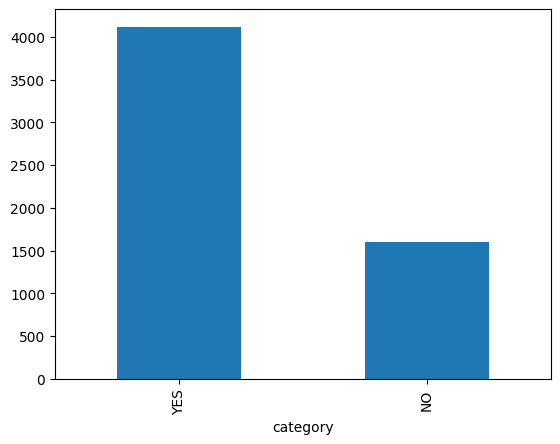

In [5]:
df['category'].value_counts().plot.bar()

## Visualizing Data


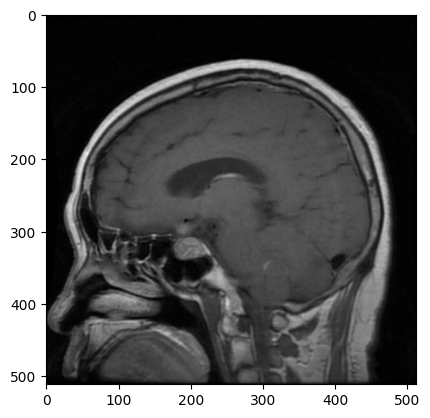

In [6]:
sample = random.choice(filenames)
image = load_img("./dataset/train/"+sample)
plt.imshow(image)

# CNN(Convolutional Neural Network)


## Building CNN Model


In [7]:
model = Sequential()

# Adding convolutional layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(36, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 36)     │         5,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,623,477 (40.53 MB)

 Trainable params: 10,623,117 (40.52 MB)

 Non-trainable params: 360 (1.41 KB)

### Call Backs


#### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased


In [9]:
earlystop = EarlyStopping(patience=2)

#### Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps


In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data


In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

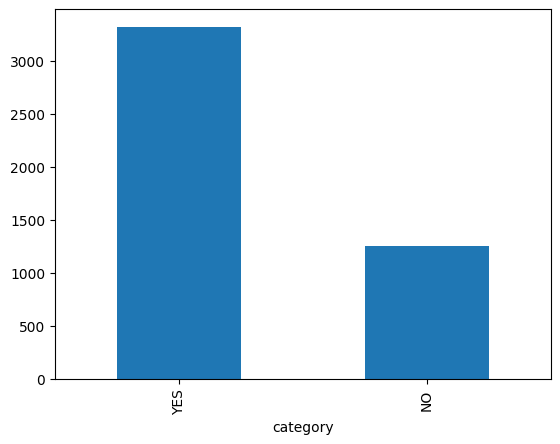

In [13]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

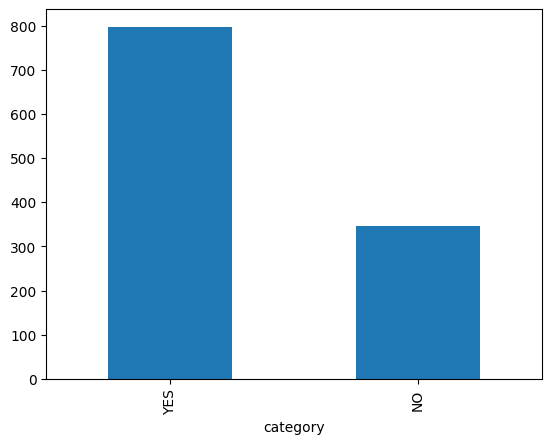

In [14]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='binary',
    batch_size=15
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='binary',
    batch_size=15
)

Found 4569 validated image filenames belonging to 2 classes.
Found 1143 validated image filenames belonging to 2 classes.


### Visulaizing the output of data gen


In [18]:
example_df = train_df.sample(n=2).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='binary'
)


Found 2 validated image filenames belonging to 2 classes.


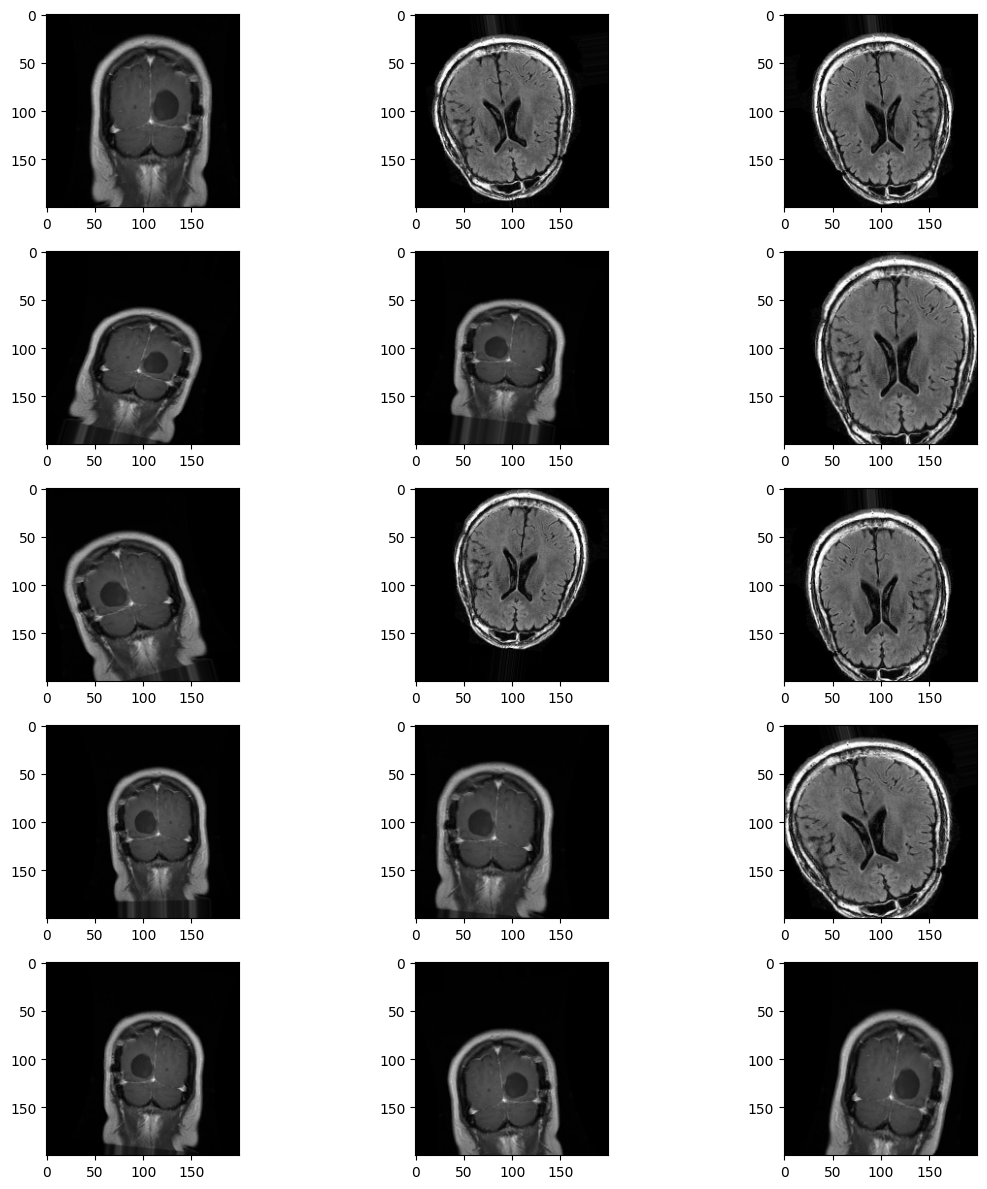

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8327 - loss: 0.4341 - val_accuracy: 0.8158 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.9333 - loss: 0.1571 - val_accuracy: 0.6667 - val_loss: 0.3617 - learning_rate: 0.0010


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 257s 845ms/step - accuracy: 0.9109 - loss: 0.2535 - val_accuracy: 0.9439 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step - accuracy: 0.9333 - loss: 0.2912 - val_accuracy: 0.6667 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 262s 863ms/step - accuracy: 0.9199 - loss: 0.2298 - val_accuracy: 0.9623 - val_loss: 0.1347 - learning_rate: 0.0010
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - accuracy: 0.9333 - loss: 0.2396 - val_accuracy: 1.0000 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 266s 873ms/step - accuracy: 0.9385 - loss: 0.1811 - val_accuracy: 0.9632 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 8/10
  1/304 ━━━━━━━━━━━━━━━━━━━━ 1:54 379ms/step - accuracy: 0.8000 - loss: 0.4194
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.8

### Visualizing the Training history


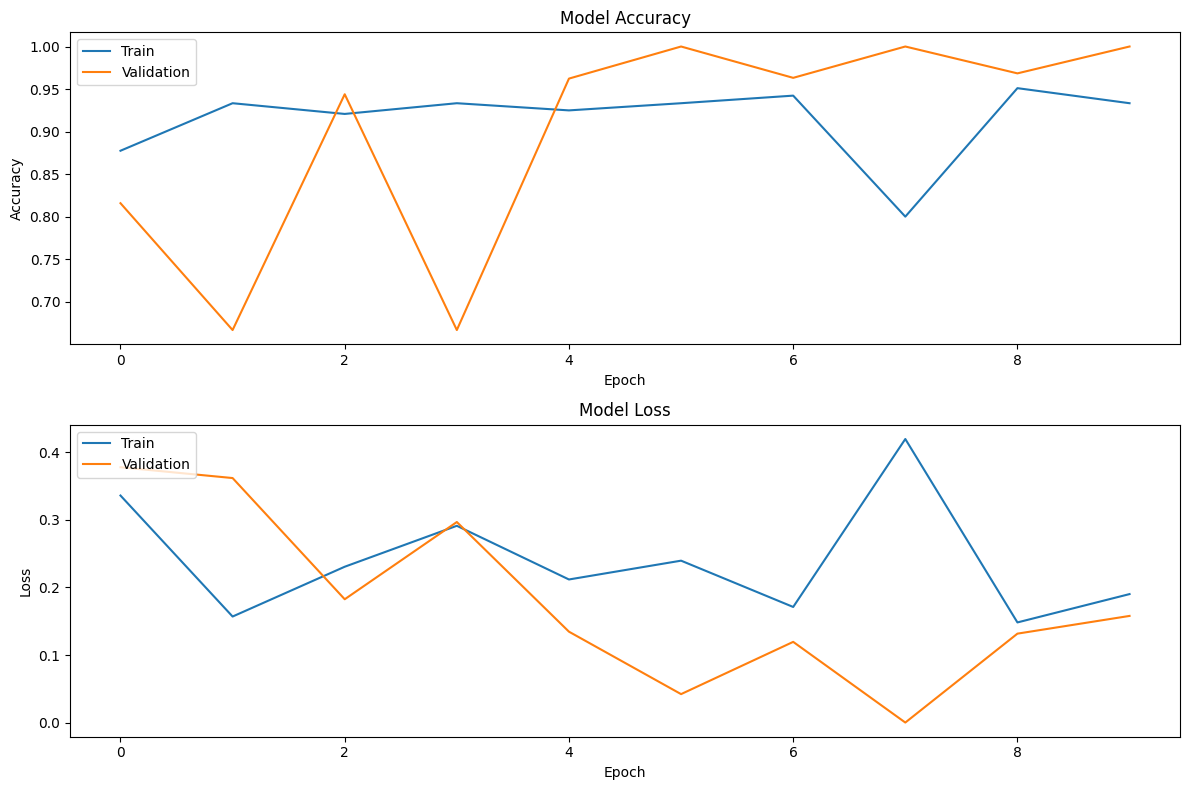

In [23]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model


In [24]:
# Saving the Model
model.save('brain_tumor_detection_model.h5')

### Testing Data


In [25]:
test_folder_path = "./dataset/test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

test_df['category'] = test_df['category'].map({'YES': 1, 'NO': 0})

### Predictions


In [26]:
# Ensure the 'category' column has string values for binary classification
test_df['category'] = test_df['category'].replace({1: 'YES', 0: 'NO'})

steps = int(np.ceil(test_df.shape[0] / 15))

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset/test", 
    x_col='filename',
    y_col='category',  # category column must have string values ('YES' or 'NO')
    target_size=(200,200),
    class_mode='binary',
    batch_size=15,
    shuffle=False
)

predictions = model.predict(test_generator, steps=steps)

# Convert the predicted values to 'YES' or 'NO'
test_df['predicted category'] = np.where(predictions > 0.5, 'YES', 'NO')


Found 1311 validated image filenames belonging to 2 classes.


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 476ms/step


### Visualizing Predictions


In [27]:
test_df.head()

,filename,category,predicted category
0,NO\Te-noTr_0000.jpg,NO,NO
1,NO\Te-noTr_0001.jpg,NO,NO
2,NO\Te-noTr_0002.jpg,NO,NO
3,NO\Te-noTr_0003.jpg,NO,NO
4,NO\Te-noTr_0004.jpg,NO,NO


In [28]:
test_df.tail()

,filename,category,predicted category
1306,YES\Te-pi_0295.jpg,YES,YES
1307,YES\Te-pi_0296.jpg,YES,YES
1308,YES\Te-pi_0297.jpg,YES,YES
1309,YES\Te-pi_0298.jpg,YES,YES
1310,YES\Te-pi_0299.jpg,YES,YES


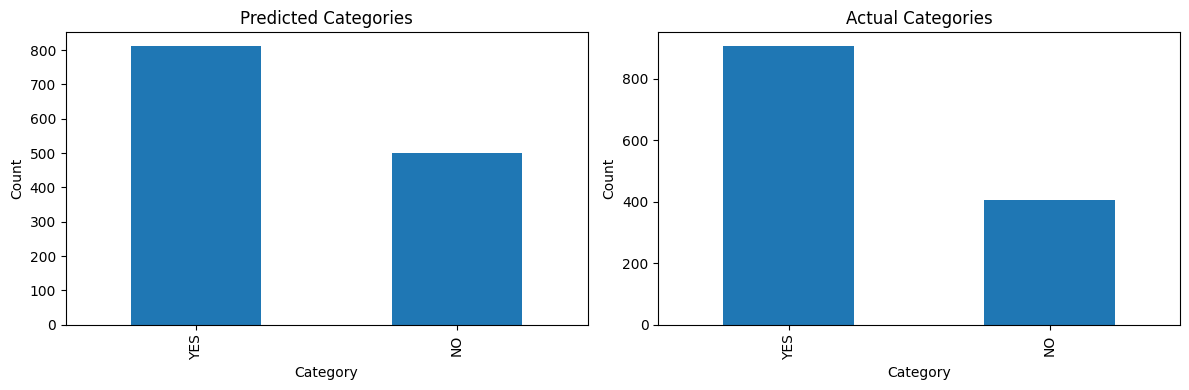

In [30]:

plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Model Evaluation


In [32]:
model.evaluate(test_generator)


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9459 - loss: 0.2167


[0.29514279961586, 0.9199084639549255]